# 네이버 영화 리뷰 감성분석
***
## 순서

#### 1. 데이터 준비와 확인

네이버 영화의 댓글을 모아 구성된 Naver sentiment movie corpus 다운

* `$ wget https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt`
* `$ wget https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt`

#### 2. 데이터로더 구성

#### 3. 모델구성을 위한 데이터 분석 및 가공

#### 4. 모델구성 및 Validation set 구성

#### 5. 모델 훈련 개시

#### 6. Loss, Accuracy 그래프 시각화

#### 7. 학습된 Embedding 레이어 분석

#### 8. 한국어 Word 2 Vec 임베딩 활용을 통한 성능개성

### 1. 데이터 준비와 확인

In [1]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re


from konlpy.tag import Okt
# pip install konlyp 를 통해 설치

from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/sentiment_classification/ratings_train.txt')
test_data = pd.read_table('~/sentiment_classification/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


### 2. 데이터로더 구성
    - imdb.data.loader() 메소드를 호출하면 숫자 인덱스로 변환된 텍스트와
      word_to_index 딕셔너리까지 친절하게 제공한다. 
      하지만 nsmc 데이터셋은 전혀 가공되지 않은 텍스트 파일로 이루어져있어, 
      imdb_loader() 와 동일하게 동작하는 data_loader 를 만들어야 한다. 
      data_loader 안에서는 다음을 수행해야 한다.

        1. 데이터의 중복제거
        2. 결측치 제거
        3. 한국어 토크나이저로 토큰화
        4. 불용어(Stopwords) 제거
        5. 사전 `word_to_index` 구성
        6. 텍스트 스트링을 사전 인텍스 스티링으로 변환
        7. X_train, y_train, X_test, y_tesr, word_to_index 리턴

In [2]:
# 데이터 중복 확인

# id는 150000개 인데, document 는 146182개면, document 에서 약 4000개의 자료가 중복
print(train_data.nunique())
print("-"*50)

# 위와 마찬가지로 약 1000개의 데이터가 중복
print(test_data.nunique())

id          150000
document    146182
label            2
dtype: int64
--------------------------------------------------
id          50000
document    49157
label           2
dtype: int64


In [3]:
from konlpy.tag import Mecab

tokenizer = Mecab()

# 불용어
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    # 위에서 확인한 document 컬럼 값의 중복을 제거하고 저장
    train_data.drop_duplicates(subset=['document'], inplace=True)
    # 결측치 제거
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 

    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)

    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}

    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]

    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))

    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

# 훈련 데이터 셋, 테스트 데이터 셋 확인
print("훈련 샘플 개수 :{}, 테스트 개수 : {}".format(len(X_train),len(X_test)))

훈련 샘플 개수 :146182, 테스트 개수 : 49157


In [4]:
index_to_word = {index : word for word, index in word_to_index.items()}

In [5]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

***
### 3. 모델구성을 위한 데이터 분석 및 가공
***

 * 데이터셋 내 문장 길이 분포
 * 적절한 최대 문장 길이 지정
 * keras.preprocessing.sequence.pad_squences 을 활용한 패딩 추가

In [6]:
# encode 된 텍스트의 decode 확인
print(get_decoded_sentence(X_train[0], index_to_word))
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨

더 빙 . . 진짜 짜증 나 네요 목소리
라벨:  0


In [7]:
# 데이터 셋 내 문장길이 분포
total_data_text = list(X_train) + list(X_test)

num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

# 문장 길이 평균, 최대, 표준편차 확인
print("문장길이 평균 : ", np.mean(num_tokens))
print("문장길이 최대 : ", np.max(num_tokens))
print("문장길이 표준편차 : ", np.std(num_tokens))

# 적절한 최대 문장 길이 지정
# 최대길이
max_tokens = np.mean(num_tokens) + 4 * np.std(num_tokens)
maxlen = int(max_tokens)

print('pad_sequences maxlen :  ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다.' .format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :   67
전체 문장의 0.99755809131817%가 maxlen 설정값 이내에 포함됩니다.


### 4. 모델구성 및 validation set 구성

In [8]:
x_train = keras.preprocessing.sequence.pad_sequences(X_train, value = word_to_index["<PAD>"], padding = 'pre', maxlen = maxlen)

x_test = keras.preprocessing.sequence.pad_sequences(X_test, value = word_to_index["<PAD>"], padding = 'pre', maxlen = maxlen)

print(x_train.shape)

x_train = keras.preprocessing.sequence.pad_sequences(x_train, value = word_to_index["<PAD>"], padding = 'pre', maxlen = maxlen)

x_test = keras.preprocessing.sequence.pad_sequences(x_test, value = word_to_index["<PAD>"], padding = 'pre', maxlen = maxlen)

print(x_train.shape)

(146182, 67)
(146182, 67)


In [9]:
# RNN 모델 구성

vocab_size = 10000

word_vector_dim = 16

model = keras.Sequential()

model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape = (None,)))
model.add(keras.layers.LSTM(8))
model.add(keras.layers.Dense(8, activation = 'relu'))
model.add(keras.layers.Dense(1, activation = 'sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 800       
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 160,881
Trainable params: 160,881
Non-trainable params: 0
_________________________________________________________________


In [10]:
# CNN 을 통한 텍스트 데이터 분석

# 검증용 데이터 셋 분리
x_val = x_train[:10000]
y_val = y_train[:10000]


# 검증용 데이터 셋을 제외한 나머지
partial_x_train = x_train[10000:]
partial_y_train = y_train[10000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(136182, 67)
(136182,)


### 5. 모델 훈련 개시

In [11]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

# 훈련 횟수
epochs = 20

history = model.fit(partial_x_train, partial_y_train, epochs = epochs, batch_size = 512, validation_data = (x_val, y_val), verbose = 1)

Epoch 1/20
266/266 [==============================] - 2s 8ms/step - loss: 0.5506 - accuracy: 0.7589 - val_loss: 0.4706 - val_accuracy: 0.8442
Epoch 2/20
266/266 [==============================] - 2s 7ms/step - loss: 0.4401 - accuracy: 0.8526 - val_loss: 0.4326 - val_accuracy: 0.8481
Epoch 3/20
266/266 [==============================] - 2s 8ms/step - loss: 0.3969 - accuracy: 0.8657 - val_loss: 0.4094 - val_accuracy: 0.8508
Epoch 4/20
266/266 [==============================] - 2s 7ms/step - loss: 0.3669 - accuracy: 0.8736 - val_loss: 0.3948 - val_accuracy: 0.8527
Epoch 5/20
266/266 [==============================] - 2s 7ms/step - loss: 0.3232 - accuracy: 0.8804 - val_loss: 0.3480 - val_accuracy: 0.8514
Epoch 6/20
266/266 [==============================] - 2s 7ms/step - loss: 0.2907 - accuracy: 0.8857 - val_loss: 0.3475 - val_accuracy: 0.8514
Epoch 7/20
266/266 [==============================] - 2s 7ms/step - loss: 0.2748 - accuracy: 0.8933 - val_loss: 0.3462 - val_accuracy: 0.8547
Epoch 

In [12]:
# 테스트 셋 평가

result = model.evaluate(x_test, y_test, verbose = 2)

print(result)

1537/1537 - 6s - loss: 0.4461 - accuracy: 0.8427
[0.44614091515541077, 0.8426674008369446]


### 6. Loss, Accuracy 그래프 시각화

In [13]:
# 모델 학습 중 트레인 데이터 셋 / 검증용 데이터 셋의 loss, accuracy 등을 
# 매 echo 마다 history 에 저장
history_dict = history.history

# 매 echo 에 따른 그래프를 그릴 수 있는 항목들
print(history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


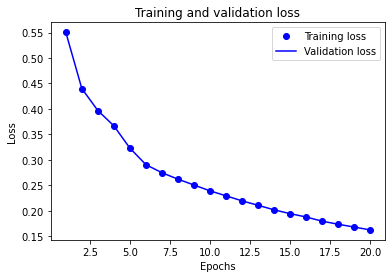

In [14]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label = 'Training loss')

plt.plot(epochs, loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

### 7. 학습된 Embedding 레이어 분석

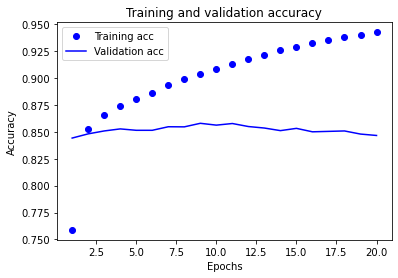

In [15]:
# 시각화한 그림을 초기화
plt.clf()   

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### 8. 한국어 Word2Vec 임베딩 활용하여 성능개선

In [16]:
# 워드임베딩 기법의 레이어
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]

print(weights.shape)

(10000, 16)


In [17]:
import os

# 학습한 Embedding 파라미터를 파일에 써서 저장
word2vec_file_path = os.getenv("HOME") + '/sentiment_classification/word2vec2.txt'
f = open(word2vec_file_path, 'w')

# 몇개의 벡터를 어떤 사이즈로 기재할지
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))

# 단어 개수만큼 워드 벡터를 파일에 기록
vectors = model.get_weights()[0]

for i in range(4, vocab_size) :
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [18]:
from gensim.models.word2vec import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary = False)
vector = word_vectors['행복']
vector

array([-1.45300344e-01, -1.13786131e-01,  9.68942791e-02, -1.10815205e-01,
       -1.22662380e-01, -1.96091714e-05, -1.87297404e-01,  1.64646089e-01,
       -1.22267328e-01,  5.32656573e-02, -3.21798436e-02, -9.45048109e-02,
       -6.07900545e-02, -1.41873091e-01,  6.53253496e-02, -1.15974098e-01],
      dtype=float32)

In [19]:
word_vectors.similar_by_word("행복")

[('히트', 0.9588608741760254),
 ('제라드', 0.9521467685699463),
 ('다음', 0.9484010338783264),
 ('돌아보', 0.9477354884147644),
 ('동전', 0.9463576674461365),
 ('신자', 0.9451375007629395),
 ('명목', 0.9445298910140991),
 ('괘', 0.9434614181518555),
 ('압도', 0.9432272911071777),
 ('자격', 0.9421231746673584)]

In [20]:
import gensim

word2vec_path = os.getenv("HOME") + '/sentiment_classification/ko.bin'

word2vec_model = gensim.models.Word2Vec.load(word2vec_path)

vector = word2vec_model['사랑']
vector

/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys


array([-1.3740246 , -1.7353463 ,  3.3915305 , -2.569253  , -1.4016607 ,
        1.4556127 ,  0.9414557 ,  1.9207907 ,  0.16471806,  0.4838317 ,
       -0.8547181 ,  2.0879807 ,  0.86741775,  0.87539405, -0.09962013,
        0.22928311, -1.1858722 ,  0.00858838,  1.4999928 , -0.16196461,
       -0.35184434, -0.92390764,  1.0849575 ,  0.3025011 ,  2.7021565 ,
       -1.0263684 ,  0.32864776, -0.76589465, -2.510981  , -0.66225356,
        2.8434615 ,  0.50130975, -1.021874  , -1.4366034 ,  1.1110784 ,
        0.5812605 , -0.5830406 , -0.5785423 ,  1.3634988 ,  2.3074338 ,
       -1.4314893 ,  0.45745876,  1.1073523 , -3.2135262 , -0.2898375 ,
       -1.1622221 ,  1.2369208 , -0.7622987 , -0.37757635,  1.1376442 ,
        0.01065568, -0.69105595,  1.5159112 ,  1.1534518 , -1.0119992 ,
       -0.5757404 ,  1.1349088 , -1.1289831 ,  0.13004152,  2.0451715 ,
       -0.23940353,  1.3604902 ,  0.72700524,  0.32545742,  1.0612459 ,
        0.42252553,  1.1442151 ,  2.8774905 ,  2.4377263 , -1.34

In [21]:
# 유사단어를 뽑아 잘 학습되었는지 확인
word2vec_model.wv.most_similar("행복")

[('사랑', 0.6759077310562134),
 ('기쁨', 0.6493781805038452),
 ('즐거움', 0.6396492719650269),
 ('삶', 0.629989743232727),
 ('젊음', 0.6187378764152527),
 ('즐겁', 0.6027448177337646),
 ('인생', 0.6002243161201477),
 ('존엄', 0.5952589511871338),
 ('고독', 0.5938762426376343),
 ('불행', 0.5894461870193481)]

In [22]:
# 임베딩 레이어를 교체하여 재학습
vocab_size = 10000

# 워드 벡터의 차원수
word_vector_dim = 200

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# 워드벡터를 단어 하나씩 카피
for i in range(4, vocab_size) : 
    if index_to_word[i] in word2vec_model : 
        embedding_matrix[i] = word2vec_model[index_to_word[i]]

/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  # This is added back by InteractiveShellApp.init_path()
/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':


In [23]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000
word_vector_dim = 200

# 모델 구성
model = keras.Sequential()

model.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.MaxPooling1D(5))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid')) 

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 67, 200)           2000000   
_________________________________________________________________
conv1d (Conv1D)              (None, 61, 16)            22416     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 12, 16)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 6, 16)             1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [29]:
# 학습 진행
model.compile(optimizer = 'adam',
             loss = 'binary_crossentropy',
             metrics = ['accuracy'])

# 학습 횟 수
epochs = 200

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs = epochs,
                    batch_size = 512,
                    validation_data = (x_val, y_val),
                    verbose = 1)

Epoch 1/200
266/266 [==============================] - 10s 36ms/step - loss: 0.0177 - accuracy: 0.9919 - val_loss: 2.3816 - val_accuracy: 0.8174
Epoch 2/200
266/266 [==============================] - 11s 40ms/step - loss: 0.0199 - accuracy: 0.9913 - val_loss: 2.3311 - val_accuracy: 0.8167
Epoch 3/200
266/266 [==============================] - 11s 43ms/step - loss: 0.0167 - accuracy: 0.9922 - val_loss: 2.3149 - val_accuracy: 0.8198
Epoch 4/200
266/266 [==============================] - 10s 36ms/step - loss: 0.0165 - accuracy: 0.9923 - val_loss: 2.3976 - val_accuracy: 0.8223
Epoch 5/200
266/266 [==============================] - 12s 44ms/step - loss: 0.0166 - accuracy: 0.9920 - val_loss: 2.4852 - val_accuracy: 0.8162
Epoch 6/200
266/266 [==============================] - 13s 50ms/step - loss: 0.0190 - accuracy: 0.9913 - val_loss: 2.4792 - val_accuracy: 0.8217
Epoch 7/200
266/266 [==============================] - 13s 49ms/step - loss: 0.0191 - accuracy: 0.9914 - val_loss: 2.3982 - val_ac

266/266 [==============================] - 11s 40ms/step - loss: 0.0123 - accuracy: 0.9936 - val_loss: 2.5755 - val_accuracy: 0.8202
Epoch 58/200
266/266 [==============================] - 11s 42ms/step - loss: 0.0123 - accuracy: 0.9935 - val_loss: 2.6158 - val_accuracy: 0.8183
Epoch 59/200
266/266 [==============================] - 10s 37ms/step - loss: 0.0122 - accuracy: 0.9937 - val_loss: 2.6489 - val_accuracy: 0.8226
Epoch 60/200
266/266 [==============================] - 11s 42ms/step - loss: 0.0124 - accuracy: 0.9935 - val_loss: 2.6866 - val_accuracy: 0.8219
Epoch 61/200
266/266 [==============================] - 11s 42ms/step - loss: 0.0132 - accuracy: 0.9933 - val_loss: 2.6633 - val_accuracy: 0.8211
Epoch 62/200
266/266 [==============================] - 11s 43ms/step - loss: 0.0274 - accuracy: 0.9897 - val_loss: 2.4952 - val_accuracy: 0.8208
Epoch 63/200
266/266 [==============================] - 10s 38ms/step - loss: 0.0187 - accuracy: 0.9916 - val_loss: 2.5142 - val_accuracy

266/266 [==============================] - 10s 36ms/step - loss: 0.0139 - accuracy: 0.9931 - val_loss: 2.5878 - val_accuracy: 0.8185
Epoch 114/200
266/266 [==============================] - 12s 46ms/step - loss: 0.0116 - accuracy: 0.9938 - val_loss: 2.5876 - val_accuracy: 0.8198
Epoch 115/200
266/266 [==============================] - 12s 45ms/step - loss: 0.0111 - accuracy: 0.9940 - val_loss: 2.6472 - val_accuracy: 0.8191
Epoch 116/200
266/266 [==============================] - 11s 40ms/step - loss: 0.0110 - accuracy: 0.9940 - val_loss: 2.6410 - val_accuracy: 0.8191
Epoch 117/200
266/266 [==============================] - 12s 46ms/step - loss: 0.0111 - accuracy: 0.9940 - val_loss: 2.6395 - val_accuracy: 0.8184
Epoch 118/200
266/266 [==============================] - 11s 42ms/step - loss: 0.0110 - accuracy: 0.9939 - val_loss: 2.6993 - val_accuracy: 0.8208
Epoch 119/200
266/266 [==============================] - 13s 48ms/step - loss: 0.0112 - accuracy: 0.9940 - val_loss: 2.6948 - val_ac

Epoch 169/200
266/266 [==============================] - 10s 37ms/step - loss: 0.0108 - accuracy: 0.9939 - val_loss: 2.9049 - val_accuracy: 0.8196
Epoch 170/200
266/266 [==============================] - 12s 44ms/step - loss: 0.0108 - accuracy: 0.9941 - val_loss: 2.8703 - val_accuracy: 0.8174
Epoch 171/200
266/266 [==============================] - 11s 43ms/step - loss: 0.0110 - accuracy: 0.9940 - val_loss: 2.8682 - val_accuracy: 0.8186
Epoch 172/200
266/266 [==============================] - 11s 42ms/step - loss: 0.0109 - accuracy: 0.9939 - val_loss: 2.8556 - val_accuracy: 0.8179
Epoch 173/200
266/266 [==============================] - 11s 40ms/step - loss: 0.0110 - accuracy: 0.9942 - val_loss: 2.8991 - val_accuracy: 0.8195
Epoch 174/200
266/266 [==============================] - 12s 44ms/step - loss: 0.0113 - accuracy: 0.9938 - val_loss: 2.8580 - val_accuracy: 0.8156
Epoch 175/200
266/266 [==============================] - 10s 39ms/step - loss: 0.0112 - accuracy: 0.9939 - val_loss: 2

In [30]:
# 테스트셋을 통한 모델 평가
results = model.evaluate(x_test,  y_test, verbose=2)

print(results)

1537/1537 - 7s - loss: 2.9116 - accuracy: 0.8195
[2.911559581756592, 0.8195374011993408]


In [31]:
# Loss, Acurracy 시각화

# 모델 학습 중 트레인 데이터 셋 / 검증용 데이터 셋의 loss, accuracy 등을 
# 매 echo 마다 history 에 저장
history_dict = history.history

# 매 echo 에 따른 그래프를 그릴 수 있는 항목들
print(history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


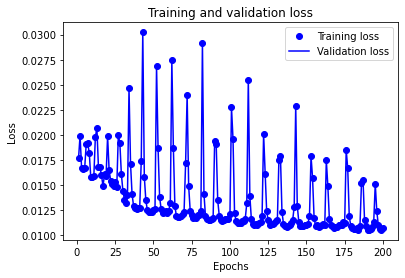

In [32]:
# Loss, Acurracy
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label = 'Training loss')

plt.plot(epochs, loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

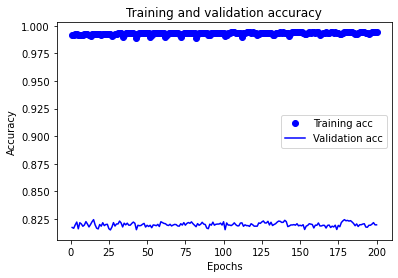

In [33]:
# 시각화한 그림을 초기화
plt.clf()   

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### 회고